# Управление рисками 2024. Домашнее задание №1.

*Дата выдачи: 06.03.2024*

*Дедлайн: 20.03.2024, 23:59*

## Часть 1. График линейности признака по WoE.

В этой части домашки мы познакомимся с одним из основных инструментов для анализа переменных в модели логистической регрессии - графиком линейности. 

Кратко идею этого графика можно сформулировать так:
 - модель *линейной* регрессии корректно применять, если значение $y$ *линейно* связано со значением $x$. Иначе линрег не подходит для данной задачи и даст неверные результаты.
 - аналогичную проверку хочется сделать и для *логистической* регрессии. Но как проверить линейность, если таргет принимает всего два значения?
 - для этого необходимо преобразовать таргет: разбить признак на бакеты и в каждом бакете посчитать WoE
 - **линейность признака по WoE для логрега – аналог линейной связи признака и таргета для линрега**

Ниже пример признака с неплохой линейностью:

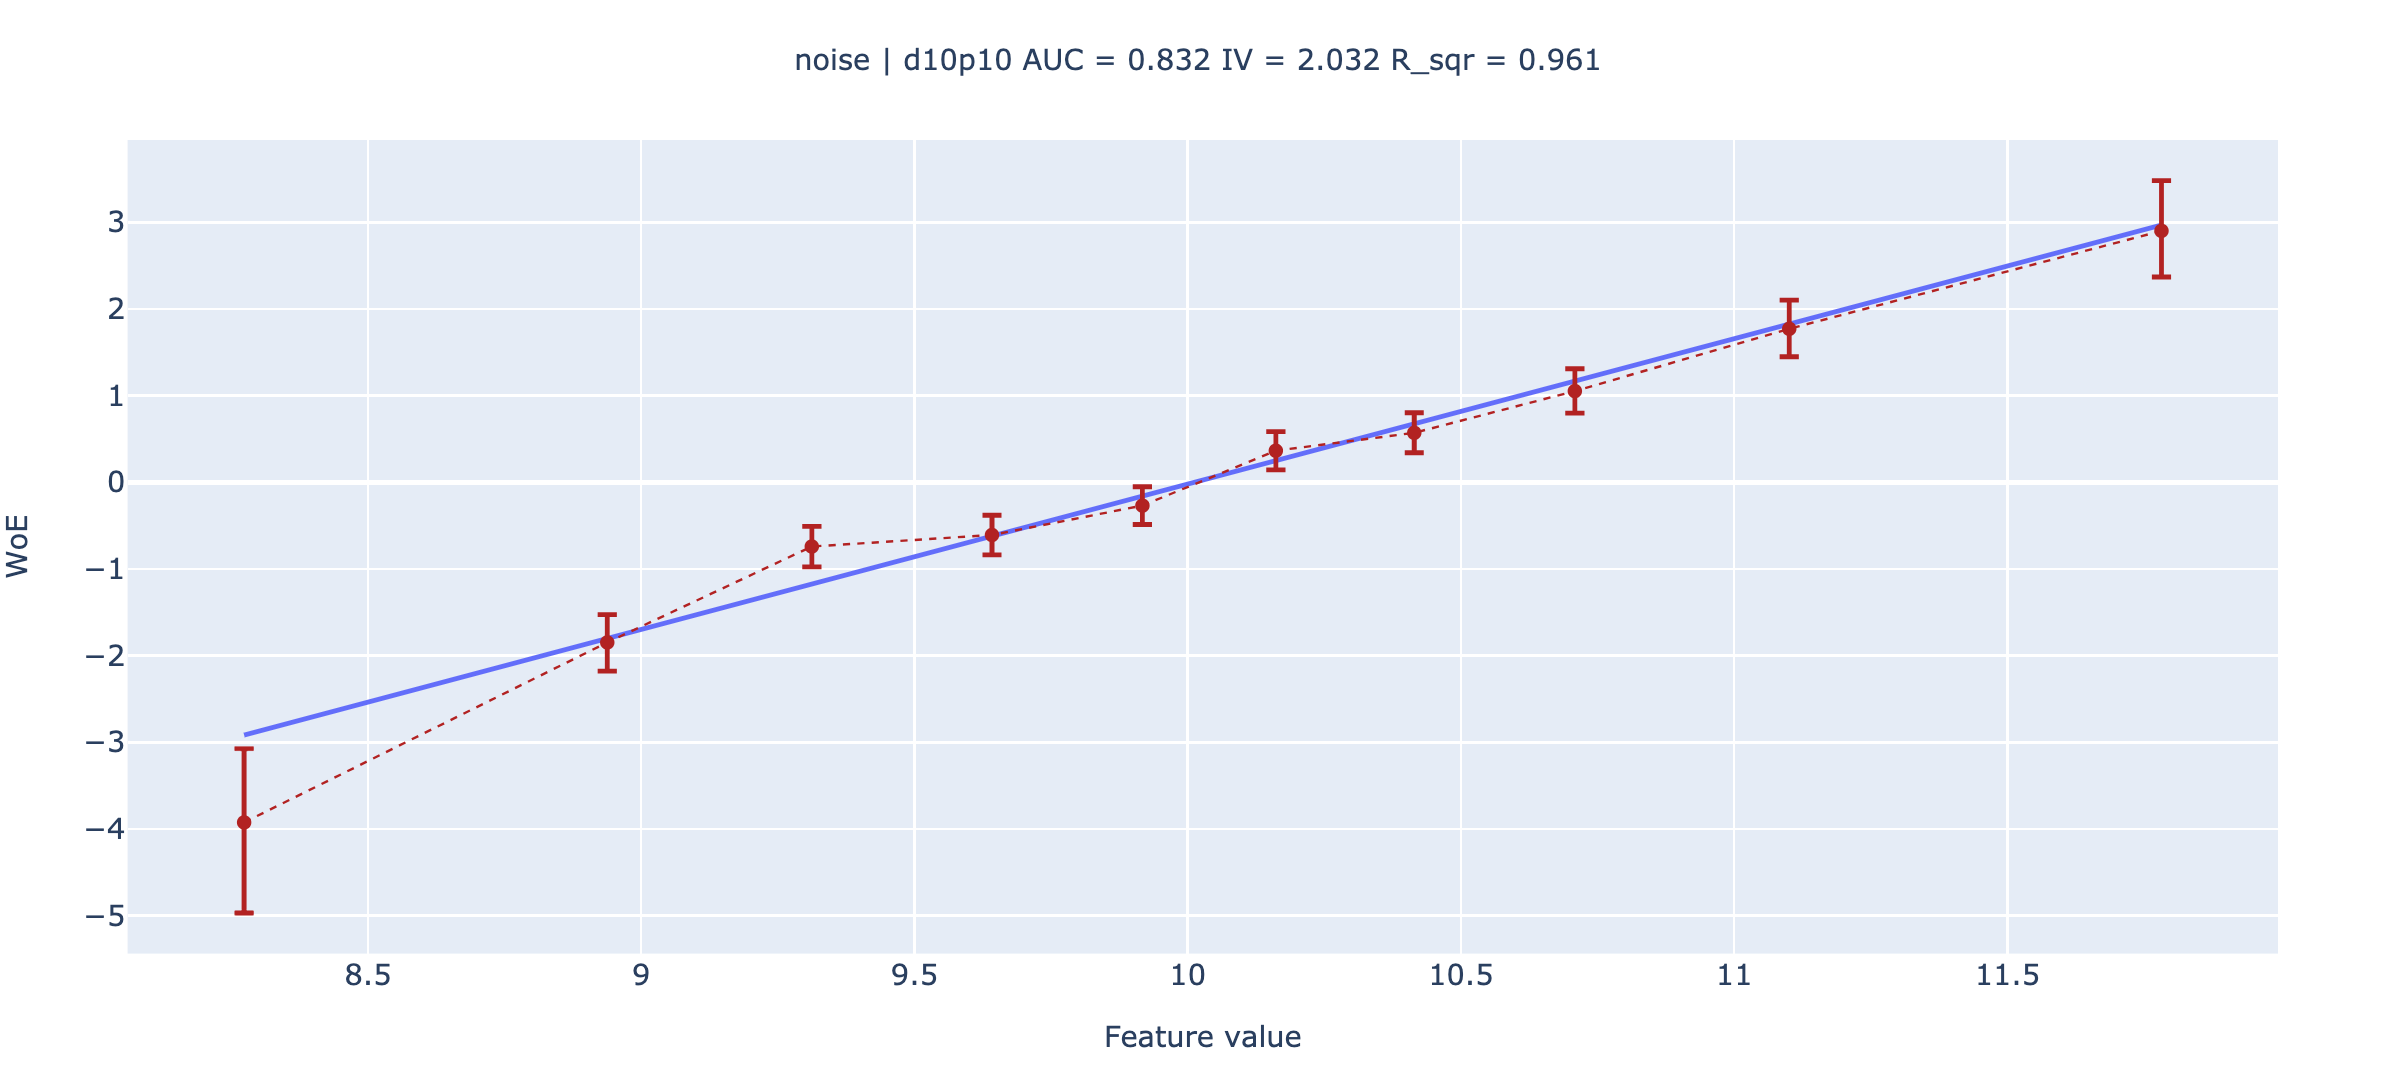

Нам нужно обратить внимание на 3 вещи:

**1. Фиолетовые точки с доверительными интервалами.**

Это WoE для каждого отдельного бакета. В идеале нам бы хотелось, чтобы **через эти точки можно было провести прямую линию** с небольшой погрешностью. Это и означает линейную взаимосвязь с таргетом.

**2. Синяя линия**

Попытка провести прямую линию через точки. Строится с помощью логистической регрессии на одной переменной. Затем предсказания переводятся в пространство WoE, отчего и получается прямая линия.

**3. Метрики в заголовке графика**

Метрики для признака:
 - roc auc, IV измеряют разделяющую способность переменной
 - $R^2$ измеряет *линейность взаимосвязи*. Признак считается линейным, если $R^2 \geq 0.95$

Далее напишем woe-line руками, чтобы в деталях разобраться, как он строится.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sps
from typing import Union, Tuple
import matplotlib.pyplot as plt

### Шаг 0: разбиение на бакеты

In [3]:
def calc_buckets(x : Union[np.ndarray, pd.Series], n_buckets : int) -> np.ndarray:
    """Разбивает массив значений признака x на 
    n_buckets бакетов"""

    x = pd.Series(x).reset_index(drop=True)
    buckets = x.rank(method="dense", pct=True) * n_buckets
    buckets = np.ceil(buckets) - 1   # np.floor дает другой результат для 5.0, 6.0 и т.д.
    buckets = np.array(buckets, dtype=np.int16)

    return buckets

In [4]:
arr = np.array([10, 5, 8, 15, 12, 7, 20, 18, 25, 30,30])
result = calc_buckets(arr, n_buckets=3)
result

array([1, 0, 0, 1, 1, 0, 2, 2, 2, 2, 2], dtype=int16)

In [5]:
arr = pd.Series([10, 5, 8, 15, 12, 7, 20, 18, 25, 30,30])
result = calc_buckets(arr, n_buckets=5)
result

array([1, 0, 1, 2, 2, 0, 3, 3, 4, 4, 4], dtype=int16)

### Шаг 1: расчет WoE по бакетам

Пусть $x_i \in \{ 0, 1\}^n$

$x_i$ - это вектор, состоящий из значений таргета *в одном бакете* $i$. 

Для бакета можно посчитать количество единиц $B_i$ (bads, выпавшие в дефолт) и количество нулей $G_i$ (goods).

$$
B_i = \sum_{j \in x_i} \mathbb{I} \{ j = 1\}\quad G_i = \sum_{j \in x_i} \mathbb{I} \{ j = 0\}
$$

Также число бэдов и гудов можно посчитать и **для всей выборки**: 

$$
% X = x_1 \cup x_2 \ldots \cup x_n
X = \{x_1,\; x_2\; \ldots\; x_n\}
$$

$$
B = \sum_{j \in X} \mathbb{I} \{ j = 1\}\quad G = \sum_{j \in X} \mathbb{I} \{ j = 0\}
$$

Тогда WoE можно посчитать как

$$
\text{WoE}_i(x) = \ln \Big ( \frac{B_i}{G_i} \Big ) - \ln \Big ( \frac{B}{G} \Big ) 
$$

**Задание**

Убедиться, что

$$
\text{WoE}_i(x) = \text{logit}(b_i) - \text{logit}(b)\quad  (1)
$$

где 

$$
b = \frac{B}{B + G}\quad \text{logit}(p) = \ln \Big (  \frac{p}{1 - p} \Big )
$$

В дальнейшем будем считать WoE по формуле $(1)$

In [6]:
from scipy.special import logit

def woe_transform(badrate : float, offset : float) -> float:
    """Считаем WoE для бакета с данным badrate и выборки
    с данным offset."""
    
    return logit(badrate)-offset 


Здесь и далее предлагается протестироать получившиеся функции. Нужно проверить, что
 - функция не ложится с ошибкой
 - возвращает то, что ожидается

In [7]:
print(woe_transform(0.1,0.5))

#проверим что функция не ложится на крайних значениях для badrate
print(woe_transform(0,0.7)) #отсутствие дефолтников
print(woe_transform(1,0.3)) #отсутствие НЕ дефолтников

#ну и просто проверим что адекватно реагирует на отрицательные значения
print(woe_transform(-5,0.8))

-2.697224577336219
-inf
inf
nan


Ниже представлен шаблон функции, которая будет считать доверительный интервал к нашим вычислениям. Можно воспользоваться любым способом, который вам больше нравится. Для идей можно посмотреть различные способы подсчета доверительного интервала [здесь](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval).

**P. S.**
Для того, чтобы построить доверительный интервал к $WoE$, можно сначала построить его для величины  $b_i = \frac{B_i}{B_i+G_i}$, а потом применить ```woe_transform```. В свою очередь величина $b_i$ является параметром распределения Бернулли, который мы можем оценить классическими методами (см. ссылку выше)

Для вычисления 95% доверительного интервала буду пользоваться этой формулой:

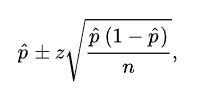

In [8]:
def woe_ci(target : np.ndarray, buckets : np.ndarray) -> Tuple[pd.Series]:
    
    woe = np.zeros_like(np.unique(buckets),dtype = float)
    woe_lower = np.zeros_like(woe, dtype = float)
    woe_upper = np.zeros_like(woe, dtype = float)
    
    offset = logit((np.sum(target)) / len(target))

    for i, bucket in enumerate(np.unique(buckets)):

        # Выбираем только соответствующие текущему бакету значения
        mask = (buckets==bucket)
        target_for_bucket = target[mask]
        badrate = max(0.001,min(0.999,np.sum(target_for_bucket)/len(target_for_bucket)))

        # Вычисляем доверительный интервал c учетом условий что границы доверительных интервалов могут не лежать в допустимых пределах   
        badrate_lower = min(0.999,max(0.001,badrate - 1.96 * np.sqrt(badrate * (1 - badrate) / len(target_for_bucket))))
        badrate_upper = max(0.001,min(0.999,badrate + 1.96 * np.sqrt(badrate * (1 - badrate) / len(target_for_bucket))))
        

        # Переходим к Woe
        woe_i = woe_transform(badrate, offset)

        # Вычисляем доверительный интервал для WoE
        woe_upper_i = woe_transform(badrate_upper, offset)
        woe_lower_i = woe_transform(badrate_lower, offset)

        # Сохраняем результаты для текущего бакета
        woe[i] = woe_i
        woe_lower[i] = woe_lower_i
        woe_upper[i] = woe_upper_i

    

    return woe, woe_lower, woe_upper


In [9]:
target = np.array([1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0])
arr = np.array([10, 5, 8, 15, 12, 7, 20, 18, 25, 30,30])
buckets = calc_buckets(arr, n_buckets=3)

woe_ci(target, buckets)

(array([ 0.51082562,  0.51082562, -0.58778666]),
 array([-2.05508551, -2.05508551, -7.08907634]),
 array([6.72443322, 6.72443322, 1.39916173]))

### Шаг 2: расчет линейной интерполяции

In [10]:
from sklearn.linear_model import LogisticRegression

def calc_line(values : np.ndarray, target : np.ndarray, mean_feature : np.ndarray, offset : float) -> np.ndarray:
    """Строим линейную интерполяцию для WoE."""

    # строим логистическую регрессию на одном признаке
    # и считаем ее предсказания в точках – mean_feature
    X = values.reshape(-1, 1)
    model = LogisticRegression()
    model.fit(X,target)

    proba = model.predict_proba(mean_feature.reshape(-1, 1))
    line = woe_transform(proba[:, 1], offset)

    return line


In [11]:
values = np.random.uniform(0, 10, 10)
target = ((values + np.random.normal(0, 1, 10)) > 4).astype(int)
mean_feature = np.linspace(0, 10, 10)
offset = 0.1

line = calc_line(values, target, mean_feature, offset)
line

array([-3.2843627 , -2.11127879, -0.93819489,  0.23488902,  1.40797293,
        2.58105684,  3.75414075,  4.92722465,  6.10030856,  7.27339247])

### Шаг3: собираем результаты по бакетам в один словарь

In [12]:
def calc_buckets_info(values : np.ndarray, target : np.ndarray, buckets : np.ndarray) -> dict:
    """Для каждого бакета расчитывает
     - среднее значение признака
     - линейную интерполяцию в пространстве woe
     - значение woe и доверительный интервал для него"""
    woe_all = woe_ci(target,buckets)
    buckets_info = {
            "mean_feature" : None,
            "line"         : None,
            "woe"          : None,
            "woe_lower"    : None,
            "woe_upper"    : None
        }
    offset = logit((np.sum(target)) / len(target))

    backets_len = np.bincount(buckets)
    mean_features = np.bincount(buckets, weights=values) / backets_len

    buckets_info["mean_feature"] = mean_features
    buckets_info["line"] = calc_line(values,target, mean_features, offset)
    buckets_info["woe"] = woe_all[0]
    buckets_info["woe_lower"] = woe_all[1]
    buckets_info["woe_upper"] = woe_all[2]

    return buckets_info

In [13]:
values = np.array([1,1,2,3,7,4,2, 5])
target = np.array([0, 1, 0, 0, 1, 0, 1, 1])
buckets = calc_buckets(values, 3)

print("buckets_info:")
calc_buckets_info(values, target, buckets)


buckets_info:


{'mean_feature': array([1.5, 3.5, 6. ]),
 'line': array([-0.48228127,  0.12570943,  0.88569782]),
 'woe': array([ 0.        , -6.90675478,  6.90675478]),
 'woe_lower': array([-4.59511985, -6.90675478,  3.05959545]),
 'woe_upper': array([ 4.59511985, -3.05959545,  6.90675478])}

### Шаг 4: считаем метрики признака

Рассчитаем также несколько метрик, чтобы судить о качестве признака не только по картинкам. 

Приведем формулу для IV:

$$
\text{IV}(x) = \sum_{i = 1}^{n}\Big ( \frac{B_i}{B} - \frac{G_i}{G} \Big ) \times \text{WoE}_i
$$

**Вопрос:** зачем считать ранжирующую силу признака двумя способами? Какую дополнительную информацию может дать IV относительно roc auc?

1. Эти метрики нужно отслежить вместе, тк woe показывает риски в бакете, а iv риски на всей выборке. Они дополняют друг друга
2. Достаточно вспомнить пример с лекции, когда по roc auc признак совсем не выделялся, но посчитав iv видно, что по значениям данном признака можно определить 90% дефолтников

In [14]:
from sklearn.metrics import roc_auc_score, r2_score

def calc_plot_title(
        values : np.ndarray,
        target : np.ndarray,
        buckets : np.ndarray
    ) -> str:
    """Считает для признака roc auc, IV, R^2"""
    offset = logit((np.sum(target)) / len(target))
        
    auc = roc_auc_score(target, values)
    

    WoEs = []
    IV = 0
    bad_for_target = np.sum(target)
    good_for_target =len(target) - np.sum(target)
    
    for bucket in np.unique(buckets):
        # Выбираем только соответствующие текущему бакету значения
        mask = (buckets == bucket)
        target_for_bucket = target[mask]

        # Вычисляем badrate и woe
        badrate = max(0.001, min(0.999, np.sum(target_for_bucket) / len(target_for_bucket))) #делаем так, чтобы badrate лежал в диапазоне от 0.001 до 0.999
        woe_for_bucket = woe_transform(badrate, offset)
        WoEs.append(woe_for_bucket)

        bad_for_bucket = np.sum(target_for_bucket)
        good_for_bucket = len(target_for_bucket) - np.sum(target_for_bucket)

        # Вычисляем IV
        IV += (bad_for_bucket / bad_for_target - good_for_bucket / good_for_target) * woe_for_bucket
    
    # Взвешенный R^2 
    # X - среднее в бакете, Y - woe в бакете, вес – число наблюдений в бакете
    weights = np.bincount(buckets)
    X = np.bincount(buckets, weights=values) / weights # Среднее значение признака в каждом бакете
    woe_interpolation = calc_line(values, target , X , offset)
    R_sqr = r2_score(woe_interpolation, WoEs, sample_weight=weights)

    plot_title = (        
        f"AUC = {auc:.3f} "
        f"IV = {IV:.3f} "
        f"R_sqr = {R_sqr:.3f} "
    )

    return plot_title

In [15]:
# протестируйте calc_plot_title
values = np.random.uniform(0, 5, 10)
target = ((values + np.random.normal(0, 1, 10)) > 4).astype(int)
arr = np.array([10, 5, 8, 15, 12, 7, 20, 18, 25, 30])
buckets = calc_buckets(arr, n_buckets=3)
calc_plot_title(values, target, buckets)


'AUC = 0.875 IV = 2.279 R_sqr = -120.388 '

In [16]:
# в этот код можно не въезжать :)
import plotly.graph_objects as go

def make_figure(buckets_info : dict, plot_title : str) -> go.Figure:
    """Строит график линейности."""
    fig = go.Figure()

    # общие настройки
    title = dict(
        text=plot_title,
        y=0.95,
        x=0.5,
        font=dict(size=12),
        xanchor="center",
        yanchor="top"
    )
    margin = go.layout.Margin(
        l=50,
        r=50,
        b=50,
        t=60
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["line"],
            mode='lines',
            name="interpolation_line",
            showlegend=False
        )
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["woe"],
            line=dict(
                color='firebrick',
                width=1,
                dash='dot'
            ),
            error_y=dict(
                type='data',
                symmetric=False,
                array=buckets_info["woe_upper"],
                arrayminus=buckets_info["woe_lower"]
            ),
            name="WoE",
            showlegend=False)
    )

    fig.update_layout(
        width=1000,
        height=450,
        xaxis_title=dict(
            text='Feature value',
            font=dict(size=12)
        ),
        yaxis_title=dict(
            text="WoE",
            font=dict(size=12)
        ),
        title=title,
        margin=margin
    )

    return fig

In [17]:
def woe_line(
        values : np.ndarray,
        target : np.ndarray,
        n_buckets : int
    ) -> go.Figure:
    """График линейности переменной по WoE."""
    buckets : np.ndarray = calc_buckets(values, n_buckets)
    buckets_info : pd.DataFrame = calc_buckets_info(values, target, buckets)
    plot_title : str = calc_plot_title(values, target, buckets)
    fig = make_figure(buckets_info, plot_title)
    return fig

Чтобы протестировать реализацию, сгенерируем синтетические данные:

In [18]:
sample_size = int(1e4)
noise_std = 1.

df = pd.DataFrame()
y = np.array(sample_size // 2 * [0] + sample_size // 2 * [1])
df['target']  = y

np.random.seed(89)
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
df['feature'] = x


<Axes: xlabel='feature', ylabel='Count'>

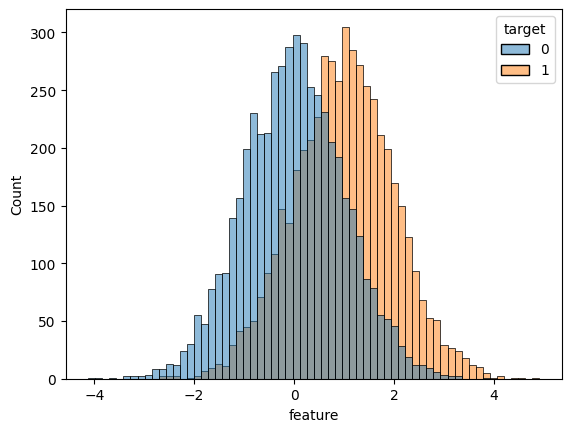

In [19]:
sns.histplot(df, x = 'feature', hue = 'target')

In [20]:
# запустите после того, как реализуете все функции 
woe_line(values=x, target=y, n_buckets=5)

### Эксперименты

#### №1

Как будут меняться график, метрики разделяющей способности и $R^2$ при изменении дисперсии шума (параметр `noise_std`)?

In [21]:
def generate_data(noise_std):
    sample_size = int(1e4)

    df = pd.DataFrame()
    y = np.array(sample_size // 2 * [0] + sample_size // 2 * [1])
    df['target']  = y

    np.random.seed(89)
    x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
    df['feature'] = x
    return df, x,y


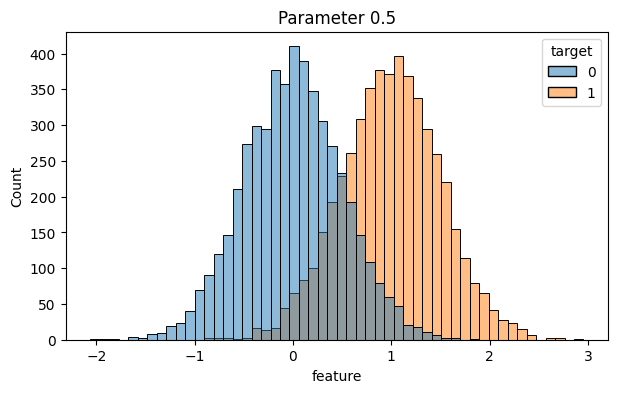

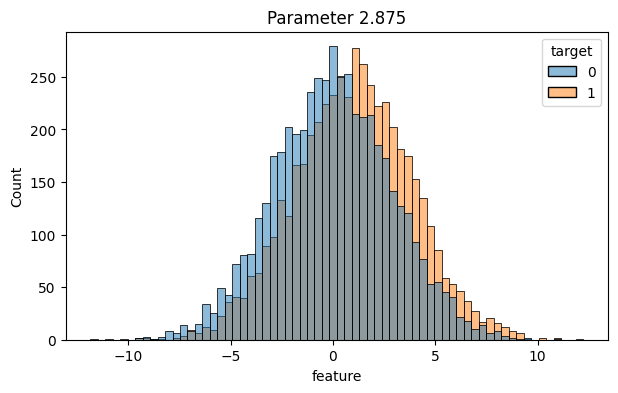

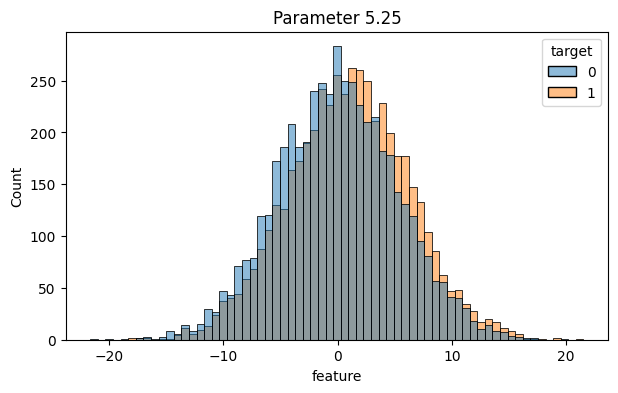

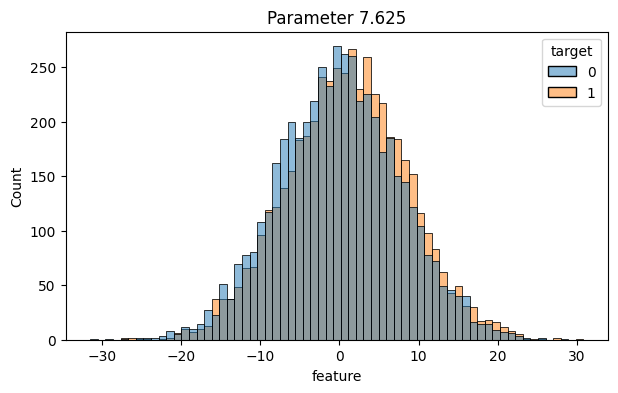

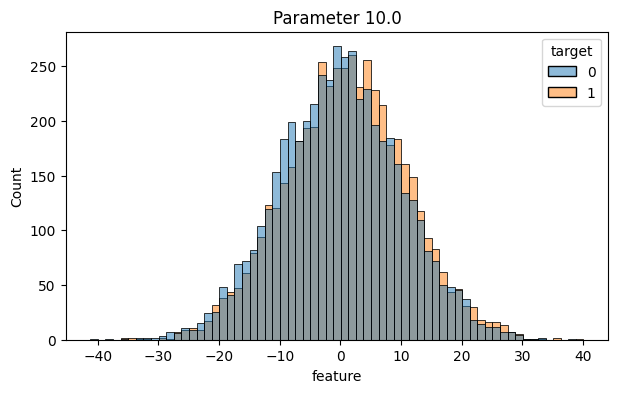

In [22]:
for i in np.linspace(0.5, 10, 5):
    fig, ax = plt.subplots(figsize=(7, 4))
    
    # Генерируем данные для текущего значения параметра
    data = generate_data(i)  
    # Строим гистограмму для текущего значения параметра
    sns.histplot(data=data[0], x='feature', hue='target', ax=ax)
    
    # Добавляем заголовок для текущего графика
    ax.set_title(f'Parameter {i}')
    plt.show()

    fig = woe_line(values=data[1], target=data[2], n_buckets=5)
    fig.show()

1. С увеличением шума IV(разделяющая способность) уменьшается. Это обьясняется тем, что с увеличением шума распределения значений таргета всё больше становятся похожими друг на друга, а как говорились на лекции, IV как раз таки показывает насколько сильно у нас отличаются распределения
2. R^2 также уменьшается. Это также обьясняется зашумленностью данных

#### №2

Запустите функцию с `values=x ** 2`. Как по графику определить эту ситуацию? Что нужно делать в таком случае?

In [23]:
woe_line(values=x ** 2, target=y, n_buckets=5)

В данном случае R^2 принимает допустимое значение, поэтому если бы я столкнулся с таким признаком я бы ничего не делал, но а вообще по графику видно, что функция похоже на корень, поэтому я бы взял корень


In [24]:
woe_line(values=np.sqrt(x ** 2), target=y, n_buckets=5)

#### №3

Запустите функцию с `values=np.exp(x)`. Как по графику определить эту ситуацию? Что нужно делать в таком случае?

In [25]:
woe_line(values=np.exp(x), target=y, n_buckets=5)

График очень похож на логарифм, поэтому в данном ситуации нужно воспользоваться np.log()

In [26]:
woe_line(values=np.log(np.exp(x)), target=y, n_buckets=5)

## Часть 2. Строим ЛогРег.

В этом пунтке попробуем применить все наши навыки 

Скачайте датасет по [ссылке](https://data.tinkoff.ru/s/Nca7PoTNYokXgNF). Пароль вы найдете в телеграм-канале курса, в посте с анонсом домашки.

In [27]:
df = pd.read_csv('risks-24-hw1.csv', index_col=0)
df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,d4p12
0,-1.444709,3.554779,1.308371,-0.689329,0.366748,2.646755,1,8.825418,2.646755,11.565953,-513.014565,-1.072893,7.936545,0.047069,B,1
1,1.132531,-0.207661,-2.142882,0.000527,2.369319,8.712916,1,3.453220,8.712916,4.935665,-39.351891,3.409855,17.015210,0.029288,A,0
2,1.268781,-0.243999,10000.000000,0.000683,0.100580,2.137392,1,-10.116061,2.137392,6.234414,-4.993050,3.121126,4.878602,0.237255,A,0
3,-1.278475,-2.579890,5.050763,-0.371907,0.523984,2.612065,1,6.780814,2.612065,2.682539,-509.273095,-1.242741,20.293025,0.907788,B,0
4,3.507807,0.152661,-8.905005,0.939313,1.092974,4.224315,1,-10.638134,4.224315,6.881602,-2.034797,2.814972,7.352399,0.276854,A,0


Как вы выдите, ```feature_1, ..., feature_14``` - числа 
```feature_15``` - категориальная фича

### Задание 0. EDA.

Как бы вы начали знакомиться с данными до построения модели? Постройте 3-5 графиков / таблиц, чтобы передать основную информацию о датасете.

In [28]:
df.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,d4p12
count,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,1.000000e+05,100000.000000
mean,-0.004065,-0.198827,-6.283870,-1.250730e-01,1.003480,2.973727,0.901520,-2.514795,2.973727,3.640370,-256.924907,1.013153,9.969348e+02,2.885691e-01,0.425370
std,2.625003,169.576125,2344.152317,5.939374e-01,1.004035,3.998071,0.297964,5.009291,3.998071,4.977886,260.742462,2.314468,4.699415e+03,3.785086e-01,0.494401
min,-54.598150,-38296.171946,-10000.000000,-1.999994e+00,0.000002,-16.569150,0.000000,-26.496544,-16.569150,-16.847030,-1012.820365,-9.210340,1.666947e-19,6.195140e-11,0.000000
25%,-1.011666,-0.385200,-4.215224,-2.289926e-01,0.288478,0.281313,1.000000,-5.893561,0.281313,0.270052,-506.548930,-1.262413,3.451754e+00,1.371482e-03,0.000000
50%,-0.058406,-0.072894,0.003200,-2.253828e-09,0.694669,2.971161,1.000000,-2.511154,2.971161,3.669848,-282.922772,-0.800022,2.341854e+01,4.439380e-02,0.000000
75%,1.004057,0.395806,4.255211,1.127132e-01,1.389851,5.663969,1.000000,0.859395,5.663969,6.984301,-0.080408,3.344923,1.536384e+02,6.085319e-01,1.000000
max,39.011329,20133.753873,10000.000000,9.999952e-01,12.006909,19.874766,1.000000,19.258719,19.874766,24.764462,446.685530,3.951220,3.729609e+05,1.000000e+00,1.000000


Видно, что у 2 и 3 фичи очень большой диапазон изменения значений. Посмотрим на их распределения

<Axes: xlabel='feature_3', ylabel='Density'>

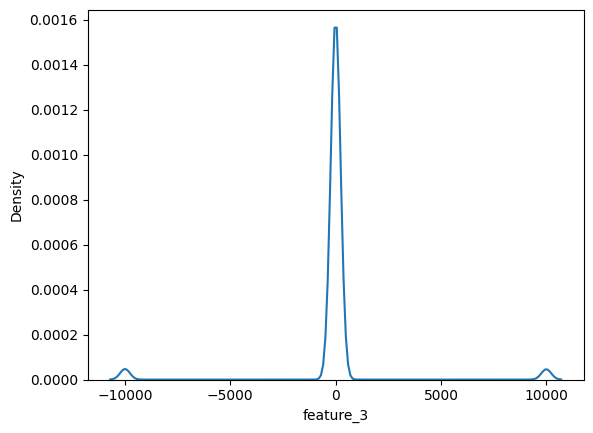

In [29]:
sns.kdeplot(df.feature_3)

<Axes: xlabel='feature_2', ylabel='Density'>

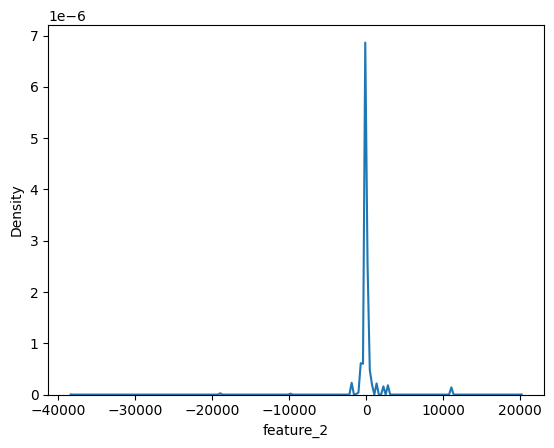

In [30]:
sns.kdeplot(df.feature_2)

Посмотрим в таблице на дефолтников и на то, есть ли пропуски

In [31]:
df.d4p12.value_counts()

d4p12
0    57463
1    42537
Name: count, dtype: int64

In [32]:
df.isna().sum()

feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
d4p12         0
dtype: int64

### Задание 1. Бейзлайн.

Попробуйте построить ЛогРег только на числовых данных. Для этого разбейте датасет на трейн и тест (80/20). Перед обучением логрега стандартизуйте переменные. Это может быть полезно для численной устойчивости алгоритмов оптимизации.

Для этой модели и всех дальнейших:

1. Получилась ли модель линейной? Постройте график линейности на трейне и на тесте и сделайте вывод.
2. Расчитайте AUC и IV на трейне и на тесте. Что можно сказать о переобучении?

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [34]:
features = df.columns[:-2]
target = 'd4p12'

train, test = train_test_split(df, test_size=0.2, random_state=0)
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), features)
])

pipeline = Pipeline(steps = [
    ('scaling', column_transformer),
    ('regression', LogisticRegression())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)
y_pred_train = model.predict_proba(X_train)

In [35]:
woe_line(values=logit(y_pred[:,1]), target=y_test, n_buckets=50)

In [36]:
woe_line(values=logit(y_pred_train[:,1]), target=y_train, n_buckets=50)

1. На трейне модель получилась линейной, но как то очень не уверенно. На тесте так вообще не линейна. Мой вывод: модель не линейна, поэтому сейчас будем работать с фичами

2. AUC и IV для трейна и теста написаны в верхней части графика. На тесте они даже увеличились, поэтому нельзя сказать что модель как то переобучилась

### Задание 2. Добавляем категориальную переменную.

Повторите задание 1, включив в модель категориальную переменную (например, с помощью one-hot encoding).

Улучшилось ли качество?

In [37]:
features = df.columns
target = 'd4p12'
categorical = ['feature_15']
numeric = df.columns[:-2]

train, test = train_test_split(df, test_size=0.2, random_state=50)
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps = [
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)
y_pred_train = model.predict_proba(X_train)

In [38]:
woe_line(values=logit(y_pred[:,1]), target=y_test, n_buckets=50)

In [39]:
woe_line(values=logit(y_pred_train[:,1]), target=y_train, n_buckets=50)

Да, качество улучшилось и не только оно, также R^2 стал >=0.95

### Задание 3. Линеаризация переменных.

На самом деле, категориальные переменные можно учитывать в моделях совсем по-другому. С их помощью можно выделить в модели сегменты. Каждому сегменту соответствует своя модель (в нашем случае логрег). 

Примером такой сегментации может стать сегментация по наличию кредитной истории. В этом случае на разных сегментах будут не просто отдельные модели, но и даже разный изначальный набор признаков. Другое свидетельство удачной сегментации – разный характер зависимости признаков и целевой переменной. Это можно увидеть на графике линейности признака по WoE. Этим мы и займемся далее.

Используйте переменную 15 для сегментации модели. На каждом из двух сегментов линеаризуйте переменные. Для этого приложите:
 - график линейности переменной до преобразования
 - график после подобранного преобразования

Помимо этого:
 - попробуйте линеаризовать какие-нибудь 2 переменные *на всей выборке*. Получилось ли у вас что-то? Постройте график.
 - по графику линейности определите шумовые (либо слабоинформативные) переменные. В конце задания приложите их список.

Пусть сегмент 1 - 'feature_15'=A, 
Сегмент 2 - B

**Первый сегмент**

In [40]:
segment_1 = df.query('feature_15 == "A"')

**1 фича**

In [41]:
woe_line(values=segment_1.feature_1.values, target=segment_1.d4p12, n_buckets=10)

In [42]:
woe_line(values=-np.log(segment_1.feature_1.values), target=segment_1.d4p12, n_buckets=10)

**2 фича**

In [43]:
woe_line(values=segment_1.feature_2.values, target=segment_1.d4p12, n_buckets=10)

In [44]:
woe_line(values = -1/(segment_1.feature_2.values), target=segment_1.d4p12, n_buckets=10)

**3 фича**

In [45]:
woe_line(values=segment_1.feature_3.values, target=segment_1.d4p12, n_buckets=10)

In [46]:
segment_1.feature_3.quantile(0.94)

4.763164598697421

In [47]:
woe_line(values=segment_1.feature_3.values.clip(segment_1.feature_3.min(),4.763164598697421), target=segment_1.d4p12, n_buckets=10)

**4 фича**

In [48]:
woe_line(values=segment_1.feature_4.values, target=segment_1.d4p12, n_buckets=50)

**5 фича**

In [49]:
woe_line(values=segment_1.feature_5.values, target=segment_1.d4p12, n_buckets=50)

**6 фича**

In [50]:
woe_line(values=(segment_1.feature_6.values), target=segment_1.d4p12, n_buckets=50)

**7 фича**
Ее не трогаем, она бинарная

**8 фича**

In [51]:
woe_line(values=(segment_1.feature_8.values), target=segment_1.d4p12, n_buckets=50)

**9 фича**

In [52]:
woe_line(values=(segment_1.feature_9.values), target=segment_1.d4p12, n_buckets=50)

**10 фича**

In [53]:
woe_line(values=(segment_1.feature_10.values), target=segment_1.d4p12, n_buckets=50)

**11 фича**

In [54]:
woe_line(values=(segment_1.feature_11.values), target=segment_1.d4p12, n_buckets=50)

In [55]:
woe_line(values=(1/(1 + np.exp(-segment_1.feature_11.values/30))), target=segment_1.d4p12, n_buckets=50)

**12 фича**

In [56]:
woe_line(values=(segment_1.feature_12.values), target=segment_1.d4p12, n_buckets=50)

Она уже и так линейна, ее не трогаем

**13 фича**

In [57]:
woe_line(values=(segment_1.feature_13.values), target=segment_1.d4p12, n_buckets=50)

**14 фича**

In [58]:
woe_line(values=(segment_1.feature_14.values), target=segment_1.d4p12, n_buckets=50)

In [59]:
woe_line(values=-logit(segment_1.feature_14.values), target=segment_1.d4p12, n_buckets=50)

Фичи, для которых я построил 1 график - они шумовые и слабоинформативные, тем более совсем не понятно как их линеаризовать, поэтому я их не трогал

**Сегмент 2**

In [60]:
segment_2 = df.query('feature_15 == "B"')

**1 фича**

In [61]:
woe_line(values=(segment_2.feature_1.values), target=segment_2.d4p12, n_buckets=50)

In [62]:
woe_line(values=-np.log(-segment_2.feature_1.values), target=segment_2.d4p12, n_buckets=50)

**2 фича**

In [63]:
woe_line(values=(segment_2.feature_2.values), target=segment_2.d4p12, n_buckets=50)

In [64]:
woe_line(values=1/(segment_2.feature_2.values), target=segment_2.d4p12, n_buckets=50)

**3 фича**

In [65]:
woe_line(values=(segment_2.feature_3.values), target=segment_2.d4p12, n_buckets=50)

In [66]:
segment_2.feature_3.quantile(0.1)

-3.320532018167163

In [67]:
woe_line(values=-(segment_2.feature_3.values.clip(-3.320532)), target=segment_2.d4p12, n_buckets=50)

**4 фича**

In [68]:
woe_line(values=(segment_2.feature_4.values), target=segment_2.d4p12, n_buckets=50)

**5 фича**

In [69]:
woe_line(values=(segment_2.feature_5.values), target=segment_2.d4p12, n_buckets=50)

**6 фича**

In [70]:
woe_line(values=(segment_2.feature_6.values), target=segment_2.d4p12, n_buckets=50)

**7 фича**. Бинарная, ее не трогаем

**8 фича**

In [71]:
woe_line(values=(segment_2.feature_8.values), target=segment_2.d4p12, n_buckets=50)

**9 фича**

In [72]:
woe_line(values=(segment_2.feature_9.values), target=segment_2.d4p12, n_buckets=50)

**10 фича**

In [73]:
woe_line(values=(segment_2.feature_10.values), target=segment_2.d4p12, n_buckets=50)

**11 фича**

In [74]:
woe_line(values=(segment_2.feature_11.values), target=segment_2.d4p12, n_buckets=50)

In [75]:
segment_2.feature_11.quantile([0.07,0.87])

0.07   -592.388315
0.87   -464.386304
Name: feature_11, dtype: float64

In [76]:
woe_line(values=((segment_2.feature_11.values).clip(-592.388315,-460.488729)), target=segment_2.d4p12, n_buckets=50)

**12 фича**

In [77]:
woe_line(values=(segment_2.feature_12.values), target=segment_2.d4p12, n_buckets=50)

Она уже линейна, ее не трогаем

**13 фича**

In [78]:
woe_line(values=(segment_2.feature_13.values), target=segment_2.d4p12, n_buckets=50)

**14 фича**

In [79]:
woe_line(values=(segment_2.feature_14.values), target=segment_2.d4p12, n_buckets=50)

In [80]:
woe_line(values=-logit(segment_2.feature_14.values), target=segment_2.d4p12, n_buckets=50)

Теперь попробуем разобраться с 2 переменными на всей выборке

In [81]:
woe_line(values=(df.feature_1.values), target=df.d4p12, n_buckets=50)

In [82]:
woe_line(values=-(np.abs(df.feature_1.values))**(1/4), target=df.d4p12, n_buckets=50)

In [83]:
woe_line(values=(df.feature_14.values), target=df.d4p12, n_buckets=50)

In [84]:
woe_line(values=-logit(df.feature_14.values), target=df.d4p12, n_buckets=50)

Обе фичи получилось линеаризовать, но я не очень уверен в преобразованиях над 1 фичей, тк я беру модуль и значения фичи накладываются друг на друга, но на лекции говорили, что преобразования ограничены только нашей фантазией, но злоупотреблять этим не стоит:)


В итоге можно выделить в качестве информативных и успешно линеаризованых: 1,2,3,7,11,12,14 фичи

In [85]:
df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,d4p12
0,-1.444709,3.554779,1.308371,-0.689329,0.366748,2.646755,1,8.825418,2.646755,11.565953,-513.014565,-1.072893,7.936545,0.047069,B,1
1,1.132531,-0.207661,-2.142882,0.000527,2.369319,8.712916,1,3.453220,8.712916,4.935665,-39.351891,3.409855,17.015210,0.029288,A,0
2,1.268781,-0.243999,10000.000000,0.000683,0.100580,2.137392,1,-10.116061,2.137392,6.234414,-4.993050,3.121126,4.878602,0.237255,A,0
3,-1.278475,-2.579890,5.050763,-0.371907,0.523984,2.612065,1,6.780814,2.612065,2.682539,-509.273095,-1.242741,20.293025,0.907788,B,0
4,3.507807,0.152661,-8.905005,0.939313,1.092974,4.224315,1,-10.638134,4.224315,6.881602,-2.034797,2.814972,7.352399,0.276854,A,0


In [86]:
#дропаем шумовые
df = df.drop(columns = ['feature_4','feature_5', 'feature_6','feature_8','feature_9','feature_10','feature_13'])

In [87]:
df.head()

,feature_1,feature_2,feature_3,feature_7,feature_11,feature_12,feature_14,feature_15,d4p12
0,-1.444709,3.554779,1.308371,1,-513.014565,-1.072893,0.047069,B,1
1,1.132531,-0.207661,-2.142882,1,-39.351891,3.409855,0.029288,A,0
2,1.268781,-0.243999,10000.000000,1,-4.993050,3.121126,0.237255,A,0
3,-1.278475,-2.579890,5.050763,1,-509.273095,-1.242741,0.907788,B,0
4,3.507807,0.152661,-8.905005,1,-2.034797,2.814972,0.276854,A,0


In [88]:
#линеаризуем информативные
df.loc[(df['feature_15'] == 'A'), 'feature_1'] = -np.log(segment_1.feature_1)
df.loc[(df['feature_15'] == 'A'), 'feature_2'] = -1/(segment_1.feature_2)
df.loc[(df['feature_15'] == 'A'), 'feature_3'] = segment_1.feature_3.values.clip(segment_1.feature_3.min(),4.763164598697421)
df.loc[(df['feature_15'] == 'A'), 'feature_11'] = (1/(1 + np.exp(-segment_1.feature_11/30)))
df.loc[(df['feature_15'] == 'A'), 'feature_12'] = segment_1.feature_12
df.loc[(df['feature_15'] == 'A'), 'feature_14'] = -logit(segment_1.feature_14.values)

df.loc[(df['feature_15'] == 'B'), 'feature_1'] = -np.log(-segment_2.feature_1)
df.loc[(df['feature_15'] == 'B'), 'feature_2'] = 1/(segment_2.feature_2)
df.loc[(df['feature_15'] == 'B'), 'feature_3'] = -(segment_2.feature_3.values.clip(-3.320532))
df.loc[(df['feature_15'] == 'B'), 'feature_11'] = (segment_2.feature_11.values).clip(-592.388315,-460.488729)
df.loc[(df['feature_15'] == 'B'), 'feature_12'] = segment_2.feature_12
df.loc[(df['feature_15'] == 'B'), 'feature_14'] = -logit(segment_2.feature_14.values)


### Задание 4. Финальная модель.

Обучите модели на признаках, которые вы отобрали и линеаризовали в задании 3. Пусть $logit_A$ – модель, обученная на сегменте $feature_{15} = A$. $logit_B$ – модель на втором сегменте. Тогда модель на всей выборке будем считать по формуле

$$
logit(x) = \mathbb I \{ feature_{15} = A \} \times logit_A(x) + \mathbb I \{ feature_{15} = B \} \times logit_B(x)
$$


Посчитайте для этой модели AUC и IV, оцените линейность на трейне и тесте. Сравните результаты с бейзлайном из задания 1.

Подсказка: если вы все сделали правильно, можно ожидать ROC AUC около 0.9 на тестовой выборке.

In [89]:
from sklearn.preprocessing import MinMaxScaler

train, test = train_test_split(df, test_size = 0.2, random_state=59)
features = df.columns[:-2]
target = 'd4p12'

X_train_A = train.query('feature_15 == "A"')[features]
X_train_B = train.query('feature_15 == "B"')[features]
y_train_A = train.query('feature_15 == "A"')[target]
y_train_B = train.query('feature_15 == "B"')[target]

X_test_A = test.query('feature_15 == "A"')[features]
X_test_B = test.query('feature_15 == "B"')[features]
y_test_A = test.query('feature_15 == "A"')[target]
y_test_B = test.query('feature_15 == "B"')[target]

pipeline_A = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", LogisticRegression())
])

pipeline_B = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", LogisticRegression())
])

model_A = pipeline_A.fit(X_train_A, y_train_A)
model_B = pipeline_B.fit(X_train_B, y_train_B)

y_pred_A = model_A.predict_proba(X_test_A)[:,1]
y_pred_B = model_B.predict_proba(X_test_B)[:,1]

y_pred_train_A = model_A.predict_proba(X_train_A)[:,1]
y_pred_train_B = model_B.predict_proba(X_train_B)[:,1]

predict_test = np.concatenate((y_pred_A,y_pred_B))
predict_train = np.concatenate((y_pred_train_A,y_pred_train_B))

true_values_train = np.concatenate((y_train_A.values,y_train_B.values))
true_values_test = np.concatenate((y_test_A.values,y_test_B.values))

In [90]:
woe_line(values=logit(predict_train), target=true_values_train, n_buckets=50)

In [91]:
woe_line(values=logit(predict_test), target=true_values_test, n_buckets=50)

**Вывод**

Линеарезация информативных и удаление шумовых признаков помогло нам увеличить AUC на трейне и на тесте практически на 30%, IV же увеличилось более чем на 400%, также модель стала более линейной (увеличился R^2). Линеаризация переменных помогла нам сделать модель более линеной и информативной.



# Часть 3. Бонус.

На лекции мы накопили ряд упражнений, которые стоит решить для понимания происходившего. Вы можете $\TeX$ать их прямо в ноуте (или прикреплять картинки, если так удобнее).

#### **Упражнение 1**

Для определения $WoE$ мы пользовались Теоремой Байеса. Примените ее и **покажите, что верно равенство**:

$$
\ln \left(  \frac{P(x_i|y=1)}{P(x_i|y=0)} \right) = ... = \ln \left( \frac{P(y=1|x_i)}{P(y=0|x_i)} \right) - \ln \left( \frac{P(y=1)}{P(y=0)} \right)
$$

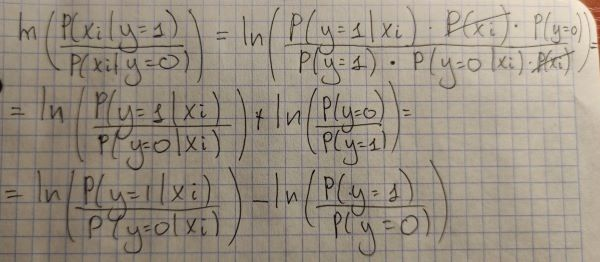

#### **Упражнение 2**

Известно:

$WoE$ можно посчитать так:
$WoE_i(x_i) = \ln \Big ( \frac{B_i}{G_i} \Big ) - \ln \Big ( \frac{B}{G} \Big ) $

Частота выхода в дефолт:  $badrate = \frac{B}{B+G}; \quad badrate_i = \frac{B_i}{B_i+G_i}$

$
\sigma (x) = \frac{1}{1+e^{-x}}; \quad logit(x) = \ln \left( \frac{x}{1-x} \right)
$

**Покажите, что**
$WoE_i(x_i) = logit(badrate_i) - logit(badrate)$

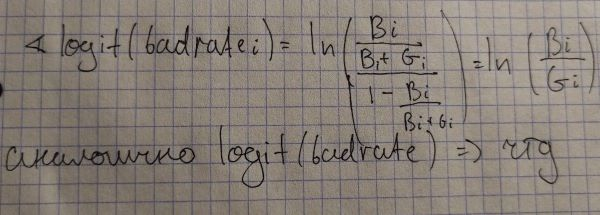

#### **Упражнение 3**

Пусть даны два дискретных распределения: 

$B=(b_1, ..., b_n)$ и $G=(g_1, ..., g_n)$.

KL-дивергенция для дискретных распределений

$$D_{KL}(B||G) = \sum_{j=1}^{n} b_j \ln \left( \frac{b_j}{g_j} \right)$$


Пусть $x$ - дикретный признак, принмиающий значения $x_1,...,x_n$.
Известно определение IV через KL-дивергенцию:

$$
IV_x = D_{KL}(B_x||G_x)+D_{KL}(G_x||B_x)
$$
где 

$$
B_x (x_i) = P(x=x_i|y=1) = b_i; \quad G_x (x_i) = P(x=x_i|y=0) = g_i
$$

**Выразите $IV$ через $WoE$**





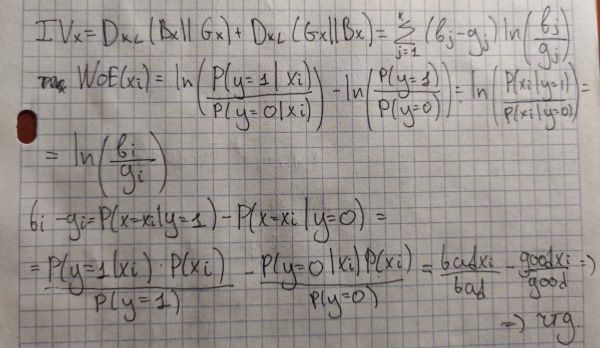